In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from astropy.table import Table

In [3]:
t = Table.read('/tmp/nnpz_compare/r_shift9/n_real_ac7e629e362cdda7b479c74222ad2c81.fits')

<IPython.core.display.Javascript object>


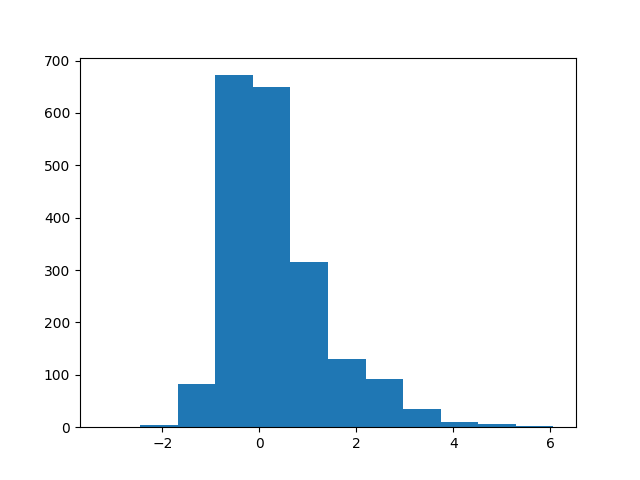

In [4]:
plt.figure()
_, bins, patches = plt.hist(np.log(t['r_obs']), bins=12)

In [5]:
grouped = []
for i in range(len(bins)-1):
    mask = np.logical_and(t['r_obs'] >= np.exp(bins[i]), t['r_obs'] < np.exp(bins[i+1]))
    grouped.append(t[mask])

# Tendency based on filter `r` flux

<IPython.core.display.Javascript object>


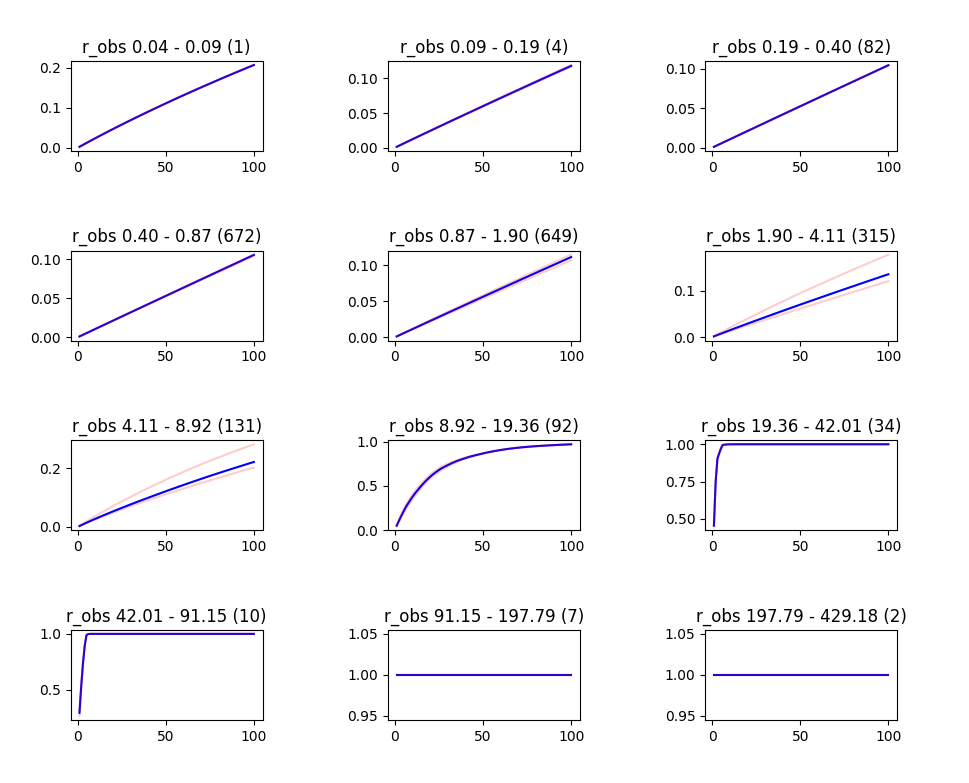

In [6]:
plt.figure()
cols = 3
rows = len(bins) / cols
total = 0
for i in range(len(bins)-1):
    plt.subplot(rows, cols, i+1)
    w_sum = np.sum(grouped[i]['NeighborWeights'], axis=1)
    w_norm = np.flip(np.sort(grouped[i]['NeighborWeights'] / w_sum[:, None]), axis=1)
    w_cumsum = np.cumsum(w_norm, axis=1)
    
    p = np.percentile(w_cumsum[:,0:100], q=[0.10,0.5,0.90], axis=0)
    _ = plt.plot(np.arange(1, 101), p[0], c='r', alpha=0.2)
    _ = plt.plot(np.arange(1, 101), p[1], c='b')
    _ = plt.plot(np.arange(1, 101), p[2], c='r', alpha=0.2)
    rmin, rmax = np.exp(bins[i]), np.exp(bins[i+1])
    plt.title(f'r_obs {rmin:.2f} - {rmax:.2f} ({len(grouped[i])})')
    total += len(grouped[i])
    
plt.tight_layout()

We can see the neighbour normalized weights depend on the magnitude of the target galaxy. The brigther it is, the further are its neighbours, so only one or two contribute importantly. In this case, we really need to nail the one or two best. If we miss those, we are missing the most contributing neighbours.

However, faint galaxies are in an overpopulated area, so we can pick 1000 neighbours and all will have (~) the same weight. In this case, it doesn't matter if we get the 40 "real best" or the second 40 "real best".

In [128]:
# Compare only this number of best real
real_subset_size = 30
sorted_indexes = []
for g in grouped:
    sorted_index = np.flip(np.argsort(g['NeighborWeights'], axis=1), axis=1)
    sorted_indexes.append(sorted_index[:, :real_subset_size])

In [155]:
def plot_matching(reference, target, indexes, color_map=plt.get_cmap('prism')):
    """
    Plot an histogram with how many neighbours from the target are in the reference
    """
    max_count = indexes.shape[1]
    counts = np.zeros(max_count + 1) # One position per count (so 0 to as many neighbours in the reference)
    for r, i, t in zip(reference, indexes, target):
        c = np.isin(r[i], t).sum()
        counts[c] += 1
    _, _, patches = plt.hist(range(max_count + 1), weights=counts, bins=max_count+1)
    for i, p in enumerate(patches):
        plt.setp(p, 'facecolor', color_map(i/max_count))
    plt.text(
        0.0, 0.2, f'0: {counts[0]}',
    )
    return counts

# Compare KDTree with 1000 neighbours

In [9]:
kdtable = Table.read('/tmp/nnpz_compare/r_shift9/n_kdtree_ed5408448bd3f94ed2c1dd3016acb578.fits')

<IPython.core.display.Javascript object>


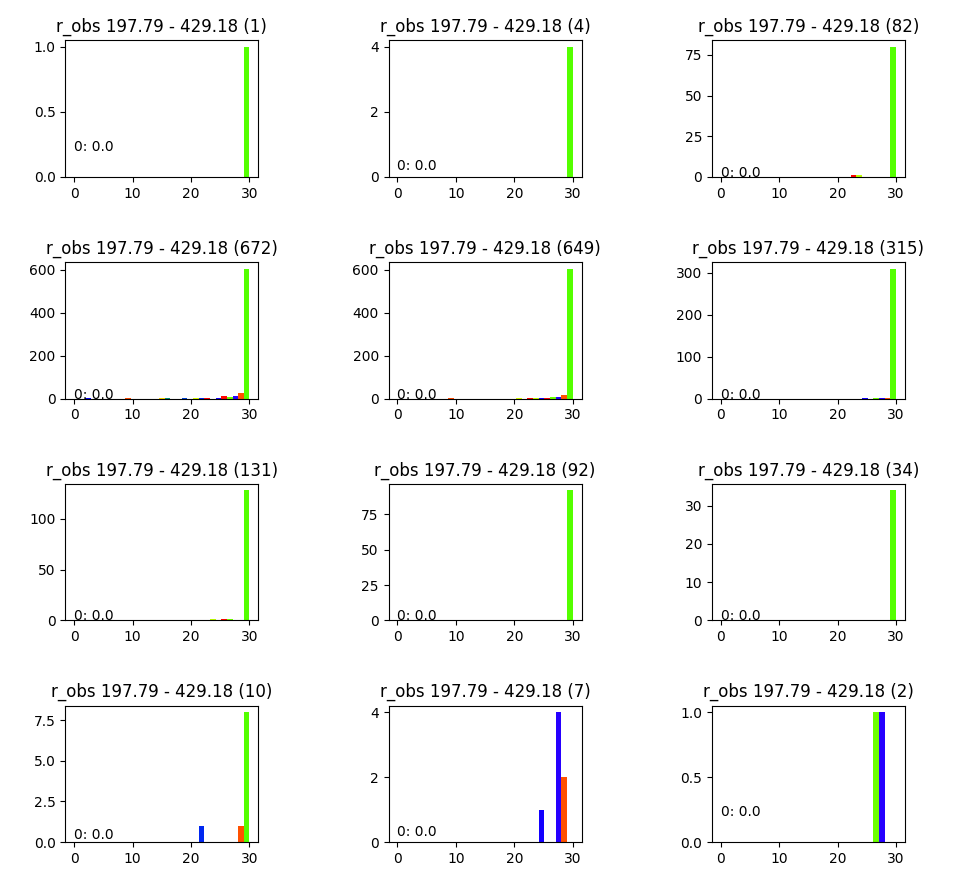

In [156]:
plt.figure()
for i in range(len(bins)-1):
    plt.subplot(rows, cols, i+1)
    # Get subset of objects from the KD result that are on this subset
    group_target_ids = grouped[i]['ID']
    kd_subset = kdtable[np.isin(kdtable['ID'], group_target_ids)]
    # Now, compare
    counts = plot_matching(
        grouped[i]['NeighborIDs'], kd_subset['NeighborIDs'], sorted_indexes[i]
    )
    plt.title(f'r_obs {rmin:.2f} - {rmax:.2f} ({len(grouped[i])})')
plt.tight_layout(pad=0., h_pad=0., w_pad=0.)

### Top-N

In [164]:
def plot_topn(reference_w, reference_i, target_i, indexes, color_map=plt.get_cmap('prism')):
    """
    Plot an histogram of the targets that have the top-N neighbours
    """
    max_count = indexes.shape[1]
    counts = np.zeros(max_count + 1)

    for rw, ri, t, i in zip(reference_w, reference_i, target_i, indexes):
        sorted_in = np.isin(ri[i], target_i)
        if sorted_in.sum() == max_count:
            counts[max_count] += 1
        else:
            counts[sorted_in.argmin()] += 1

    _, _, patches = plt.hist(range(max_count + 1), weights=counts, bins=max_count + 1)
    for i, p in enumerate(patches):
        plt.setp(p, 'facecolor', color_map(i/max_count))
    plt.text(
        0.0, 0.2, f'0: {counts[0]}',
    )

<IPython.core.display.Javascript object>


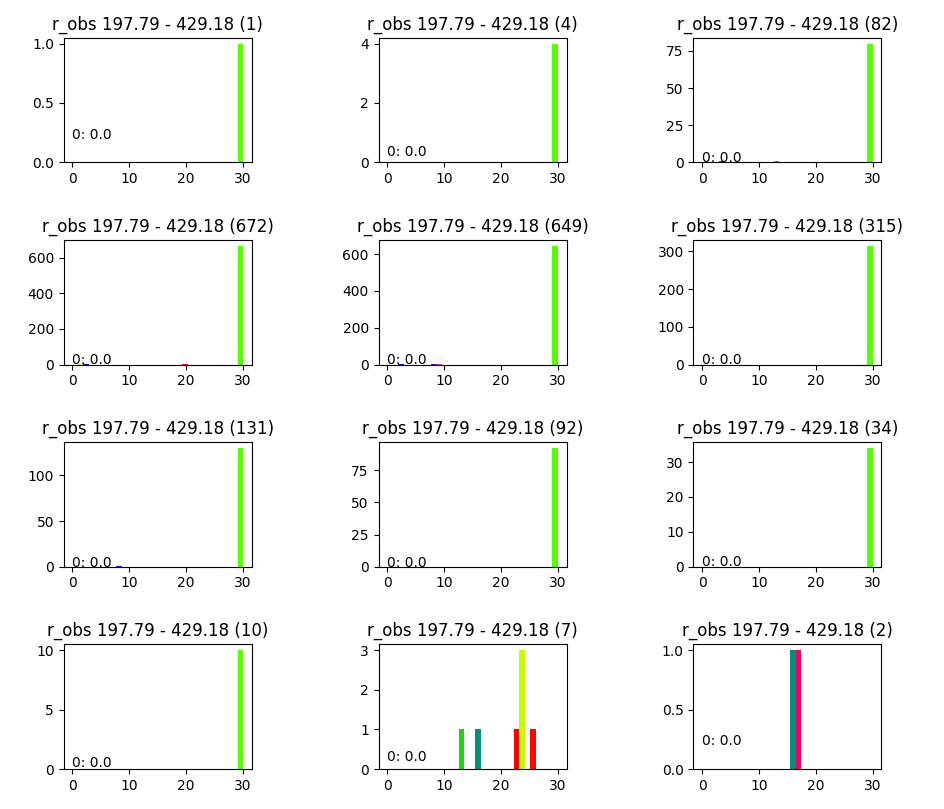

In [166]:
plt.figure()
for i in range(0,len(bins)-1):
    plt.subplot(rows, cols, i+1)
    group_target_ids = grouped[i]['ID']
    kd_subset = kdtable[np.isin(kdtable['ID'], group_target_ids)]
    plot_topn(
        grouped[i]['NeighborWeights'],
        grouped[i]['NeighborIDs'],
        kd_subset['NeighborIDs'],
        sorted_indexes[i]
    )
    plt.title(f'r_obs {rmin:.2f} - {rmax:.2f} ({len(grouped[i])})')
plt.tight_layout(pad=0., h_pad=0., w_pad=0.)

# Compare combined with 30 neighbours

In [79]:
combined = Table.read('/tmp/nnpz_compare/r_shift9/n_combined_a08afadb2b6e27aca17428816b58d99a.fits')

<IPython.core.display.Javascript object>


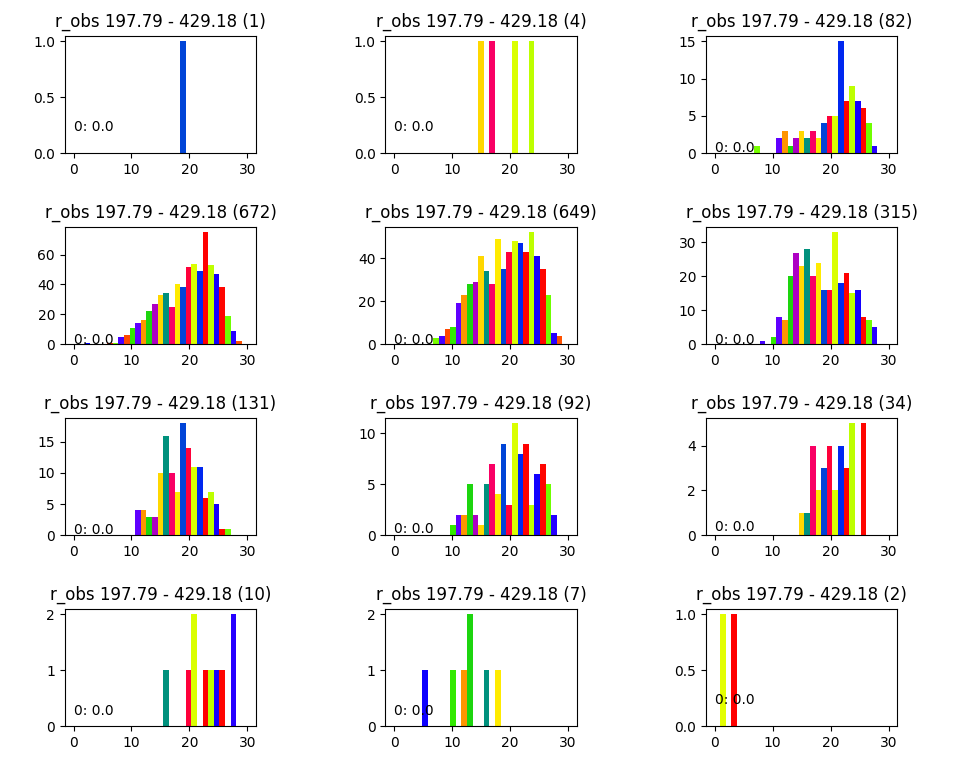

In [167]:
plt.figure()
for i in range(len(bins)-1):
    plt.subplot(rows, cols, i+1)
    # Get subset of objects from the KD result that are on this subset
    group_target_ids = grouped[i]['ID']
    combined_subset = combined[np.isin(combined['ID'], group_target_ids)]
    # Now, compare
    plot_matching(
        grouped[i]['NeighborIDs'],
        combined_subset['NeighborIDs'],
        sorted_indexes[i]
    )
    plt.title(f'r_obs {rmin:.2f} - {rmax:.2f} ({len(grouped[i])})')
plt.tight_layout(pad=0., h_pad=0., w_pad=0.)

## Top-N

<IPython.core.display.Javascript object>


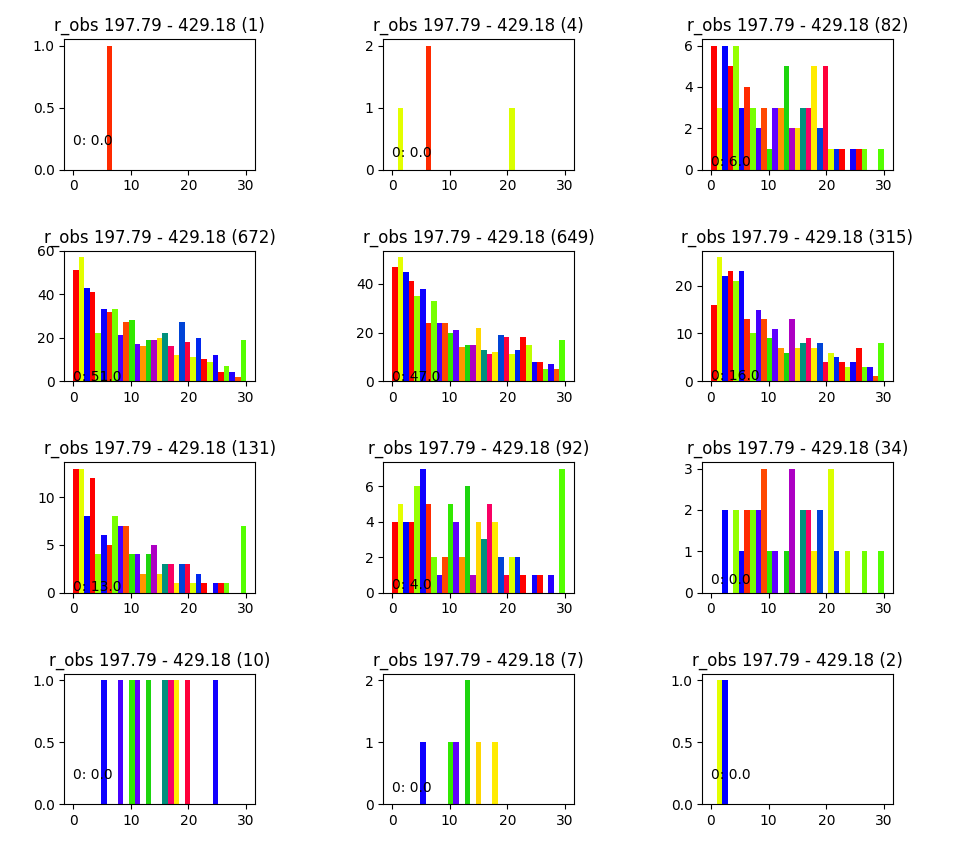

In [168]:
plt.figure()
for i in range(len(bins)-1):
    plt.subplot(rows, cols, i+1)
    group_target_ids = grouped[i]['ID']
    combined_subset = combined[np.isin(combined['ID'], group_target_ids)]
    plot_topn(
        grouped[i]['NeighborWeights'],
        grouped[i]['NeighborIDs'],
        combined_subset['NeighborIDs'],
        sorted_indexes[i]
    )
    plt.title(f'r_obs {rmin:.2f} - {rmax:.2f} ({len(grouped[i])})')
plt.tight_layout(pad=0., h_pad=0., w_pad=0.)